时间范围: 2016-07-01 02:00:00 到 2018-07-02 01:00:00
传感器数量: 861
总记录数: 17544
缺失值总数: 0

目标变量(OT)统计描述:
count    17544.000000
mean         0.031537
std          0.019453
min          0.000000
25%          0.012500
50%          0.034100
75%          0.046700
max          0.217400
Name: OT, dtype: float64


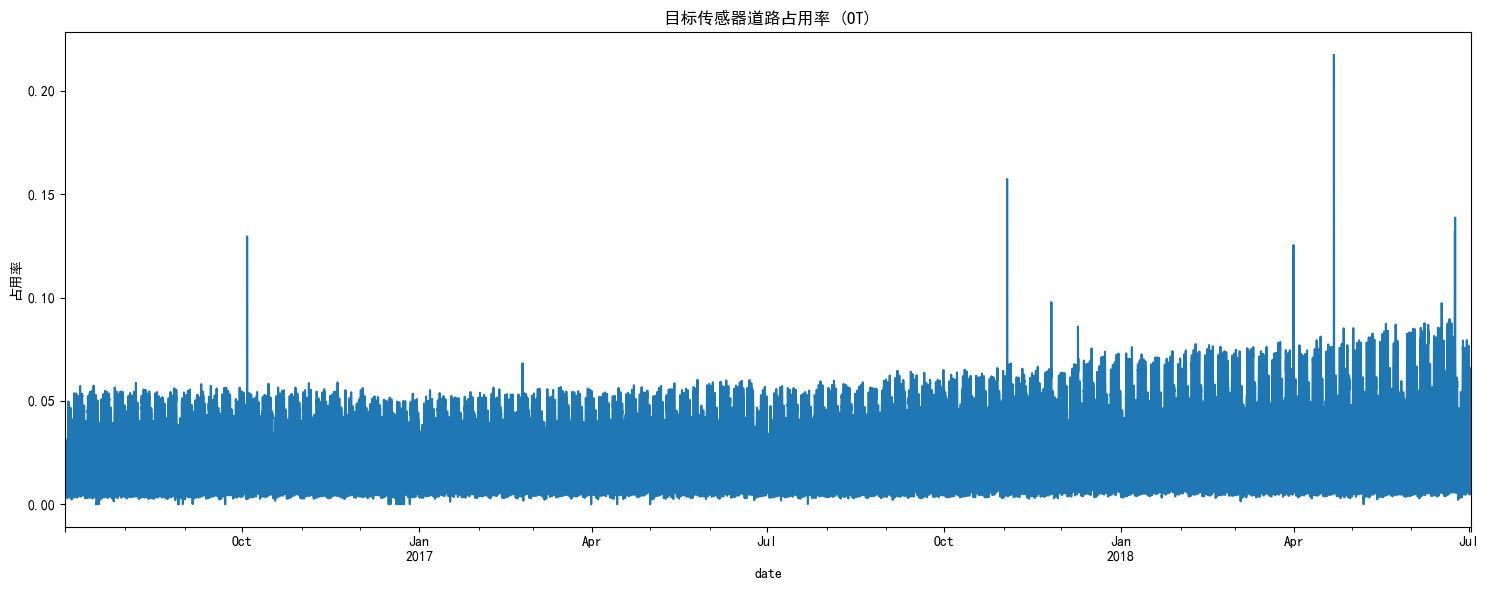

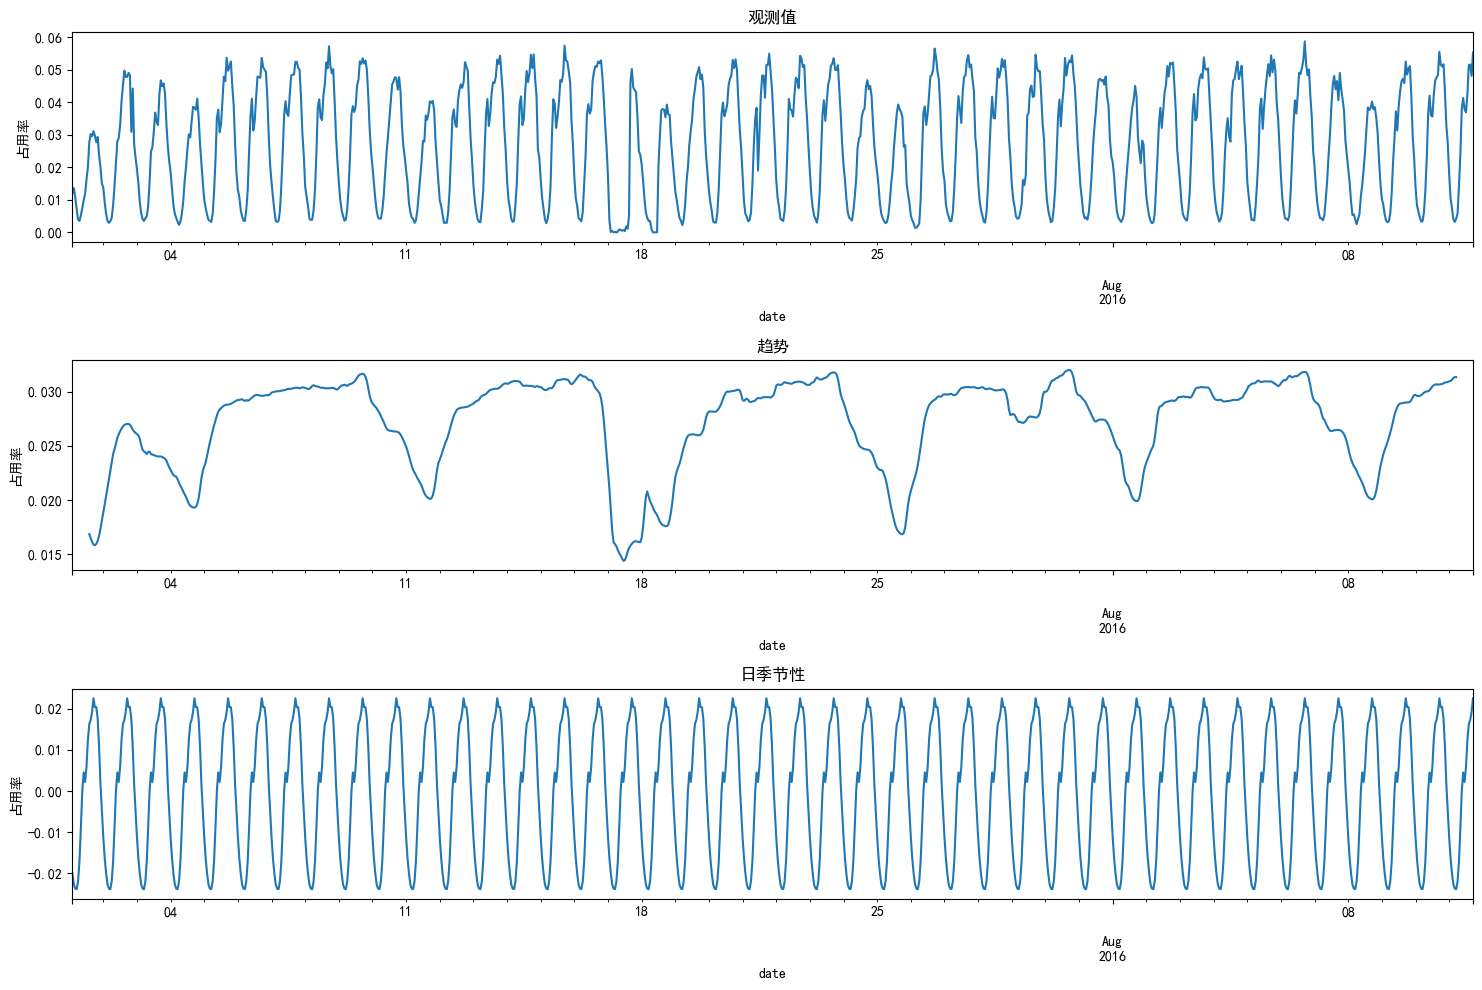


代表性传感器:
高相关传感器 857: 0.9394
中等相关传感器 813: 0.6913
低相关传感器 737: 0.1395


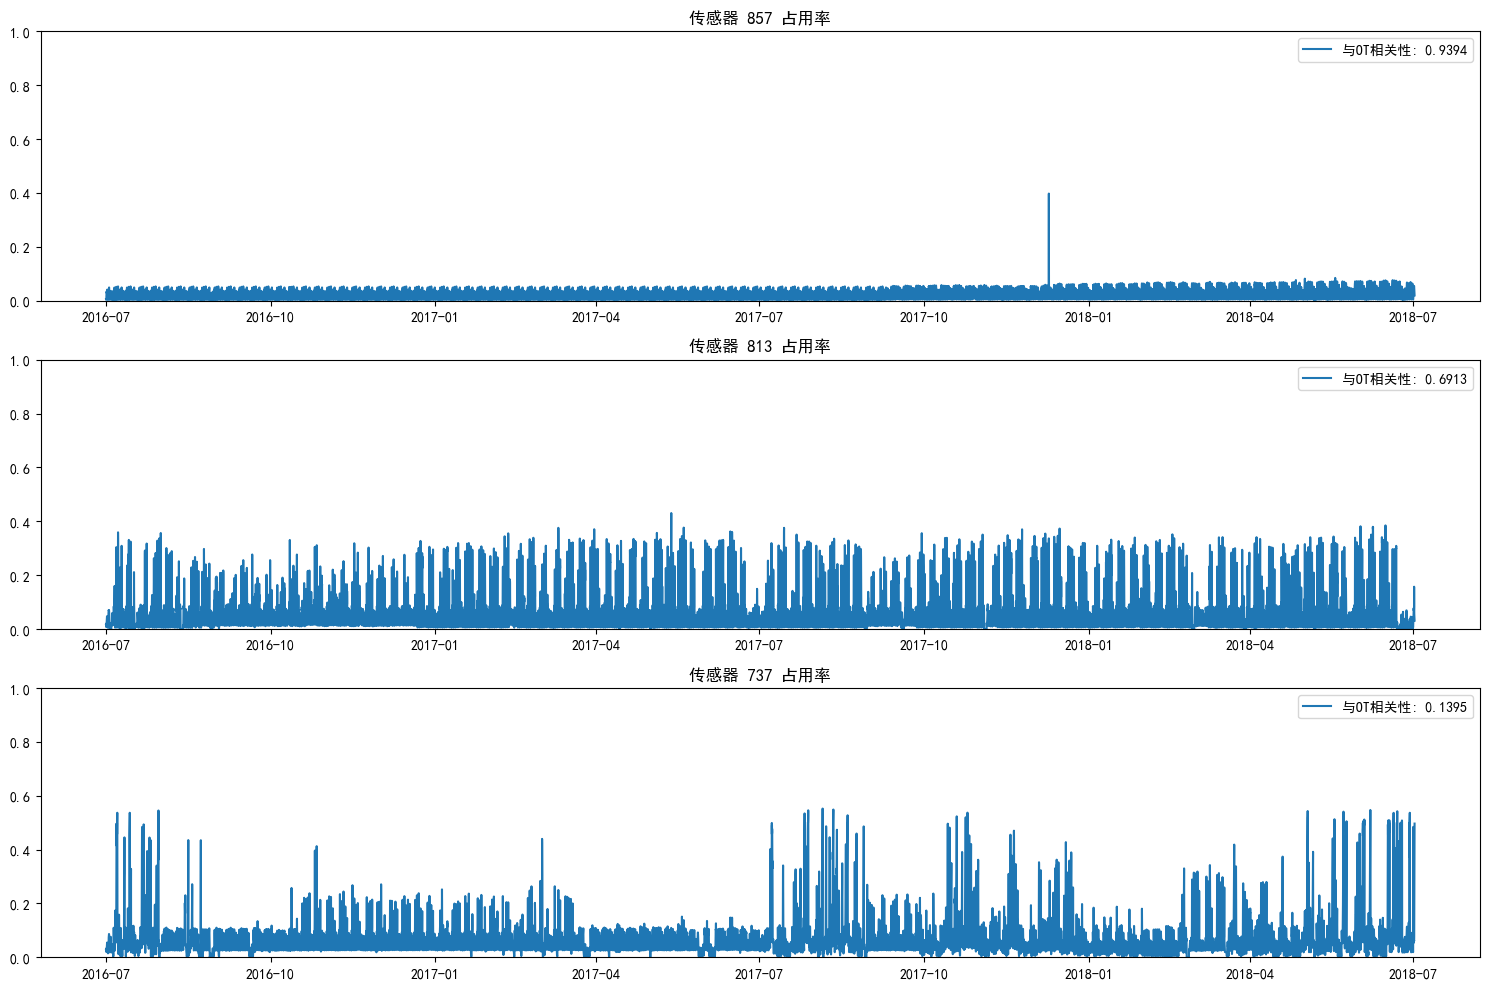

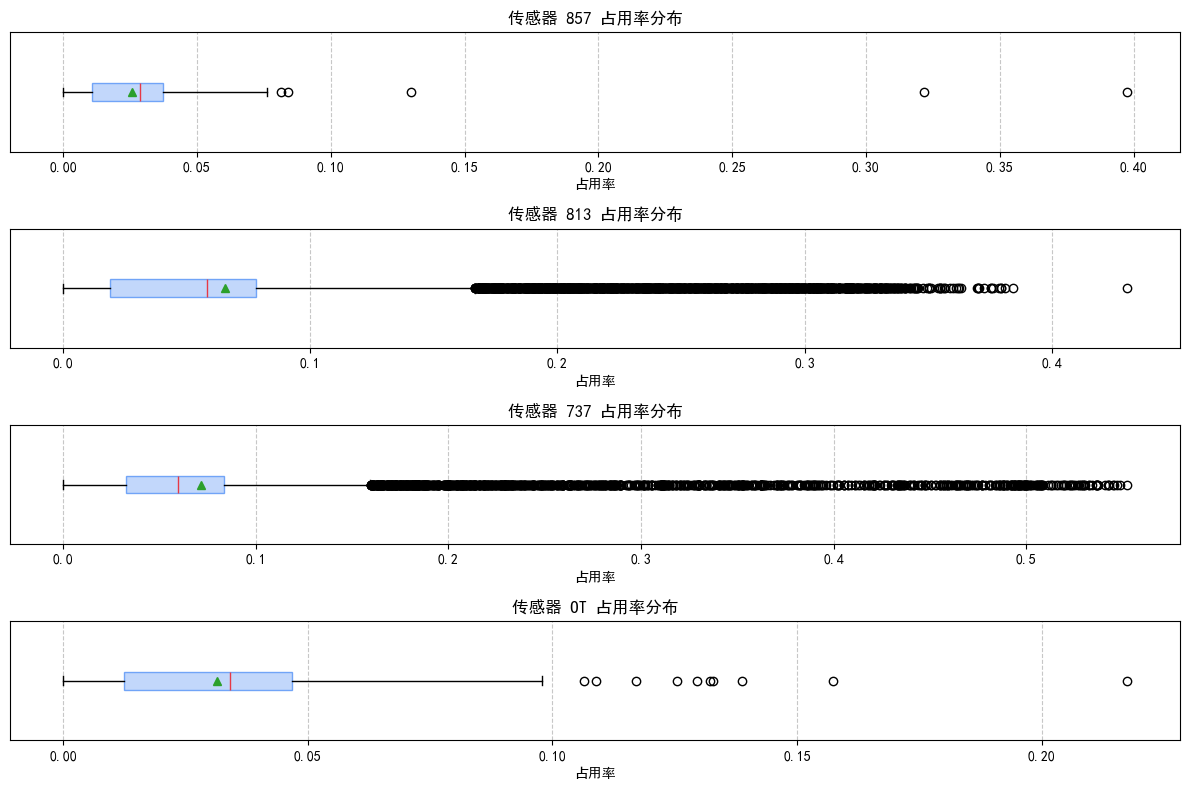

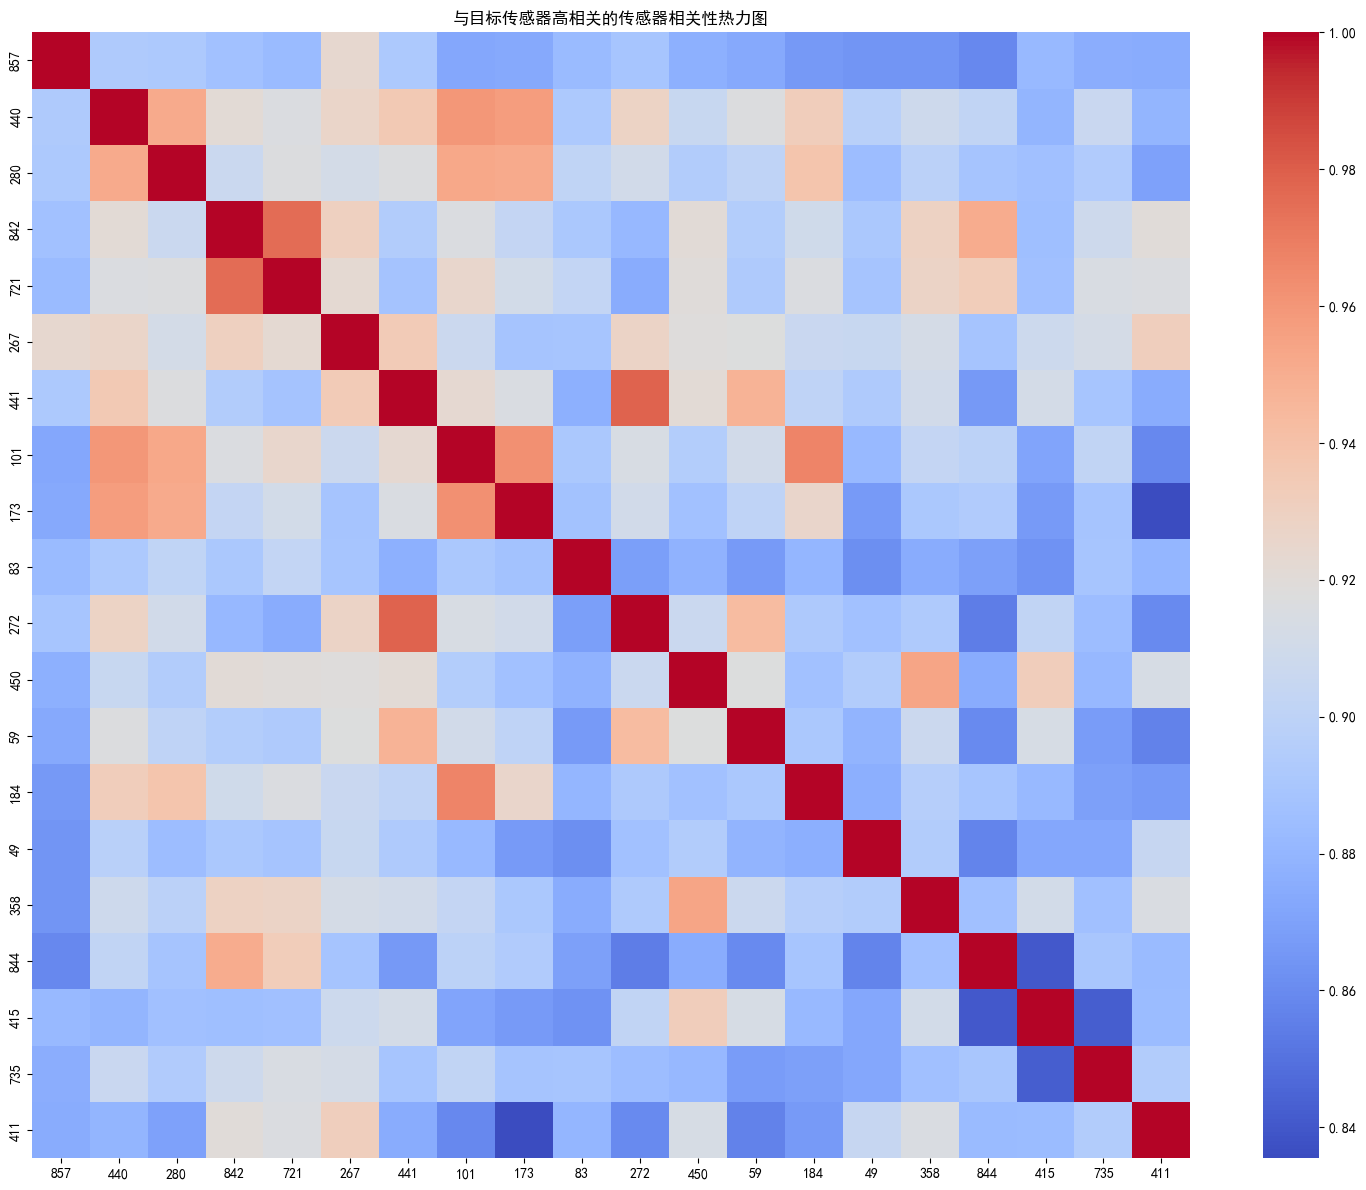

C:\Users\86180\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


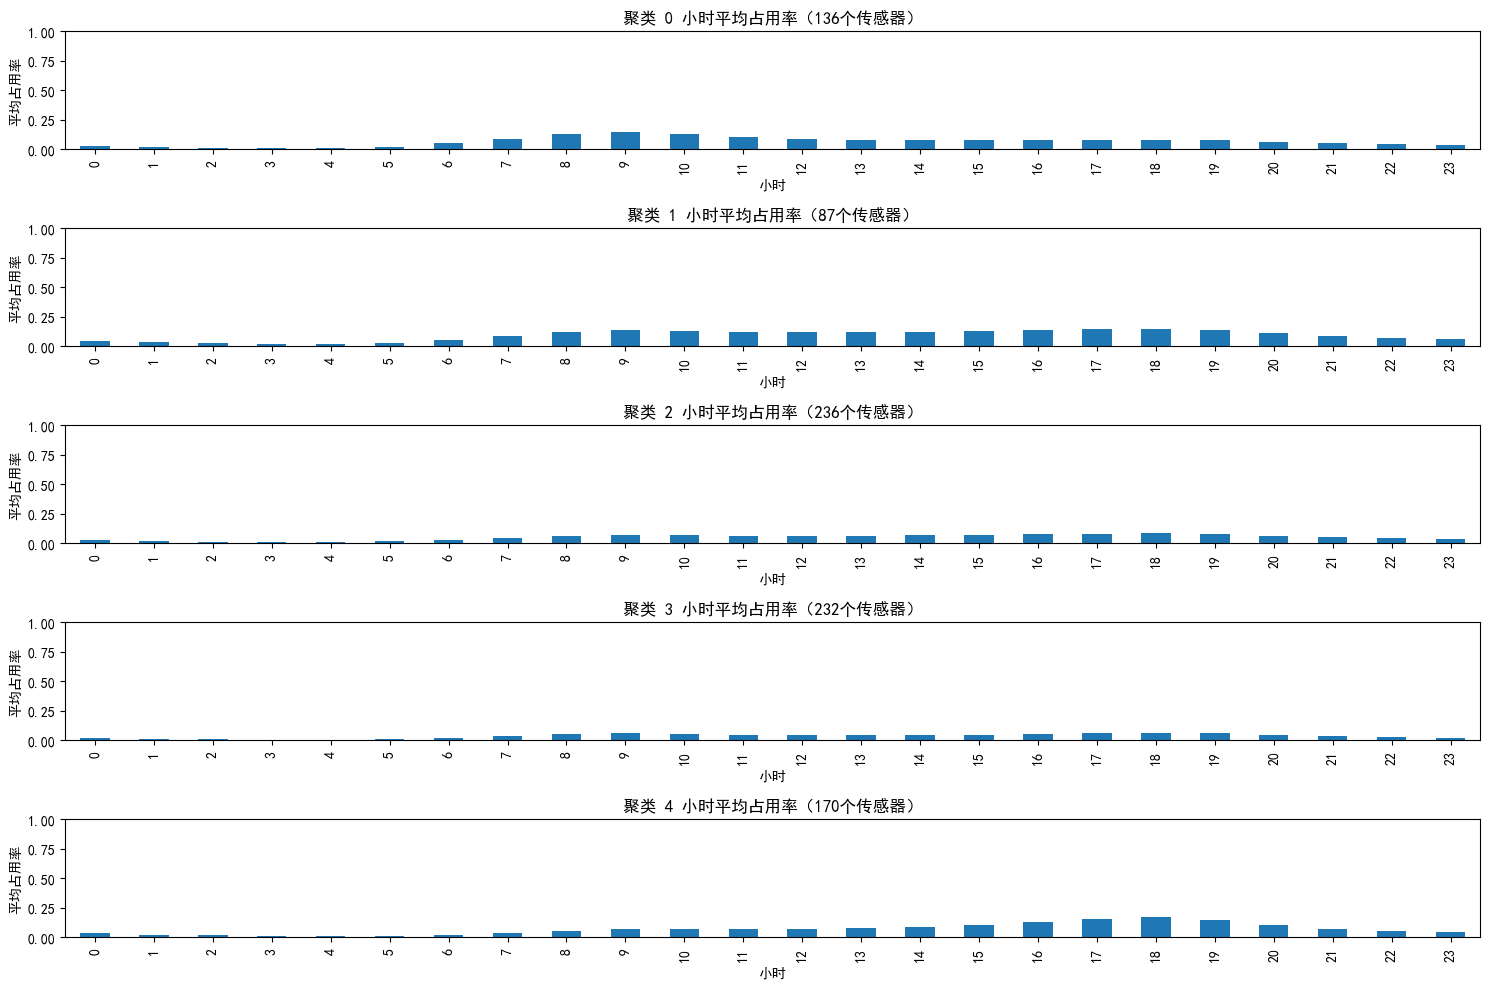

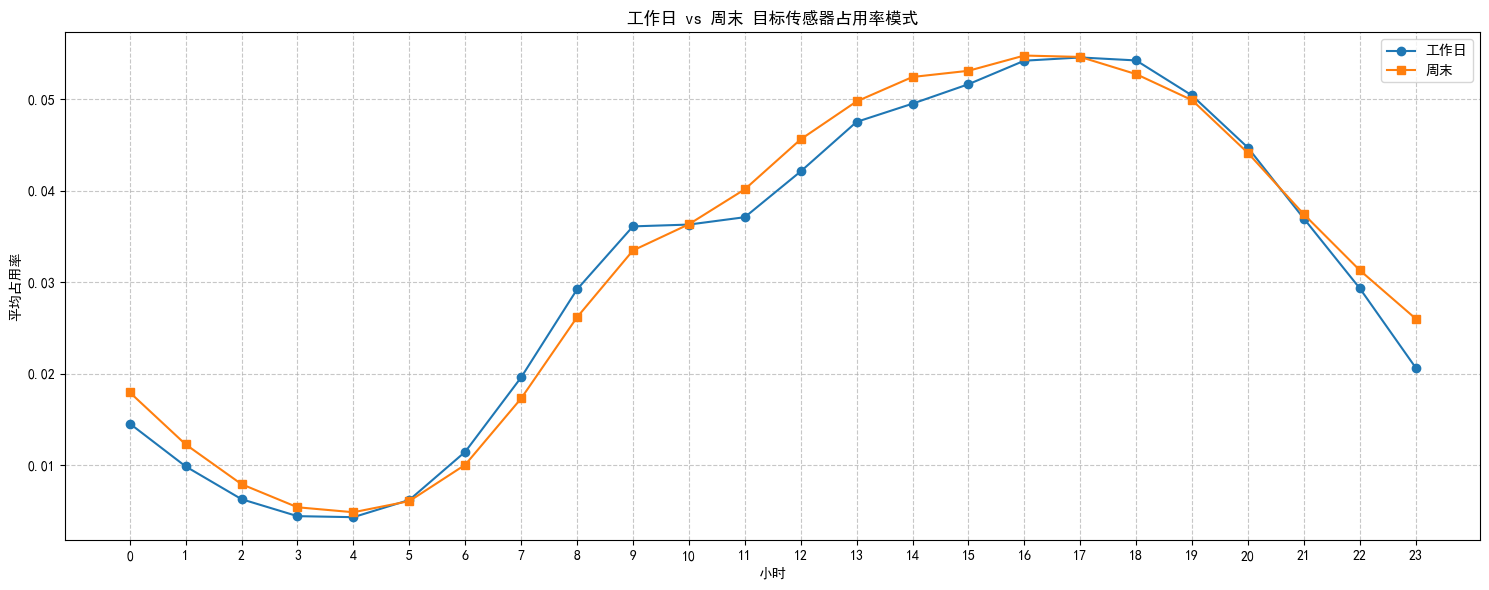

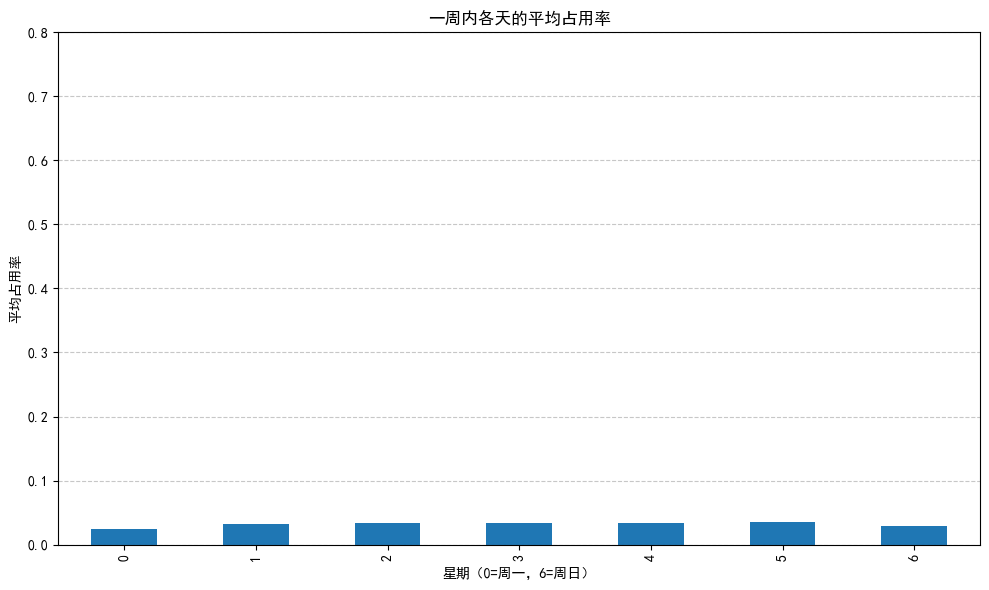


检测到异常交通事件数量: 122


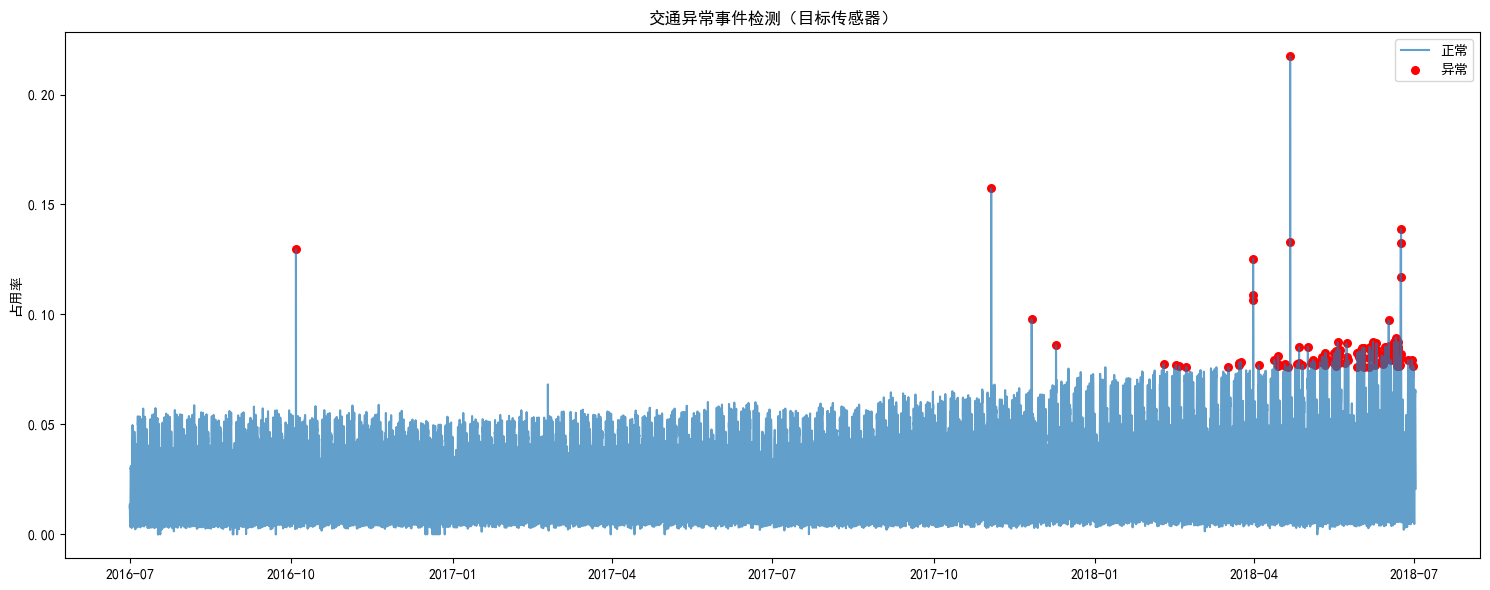

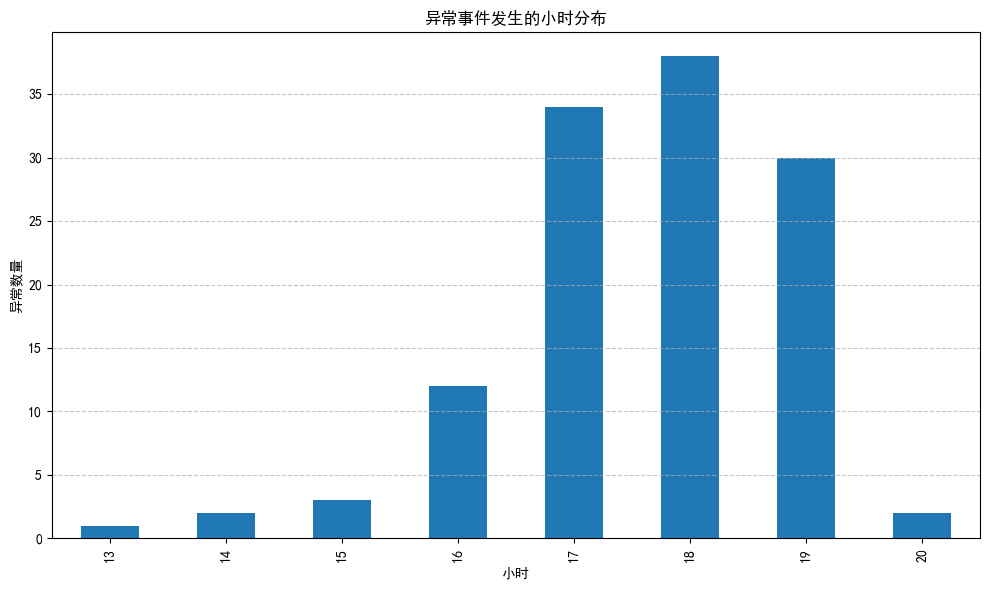


选择的 20 个重要传感器:
['49', '59', '83', '101', '173', '...', '721', '735', '842', '844', '857']


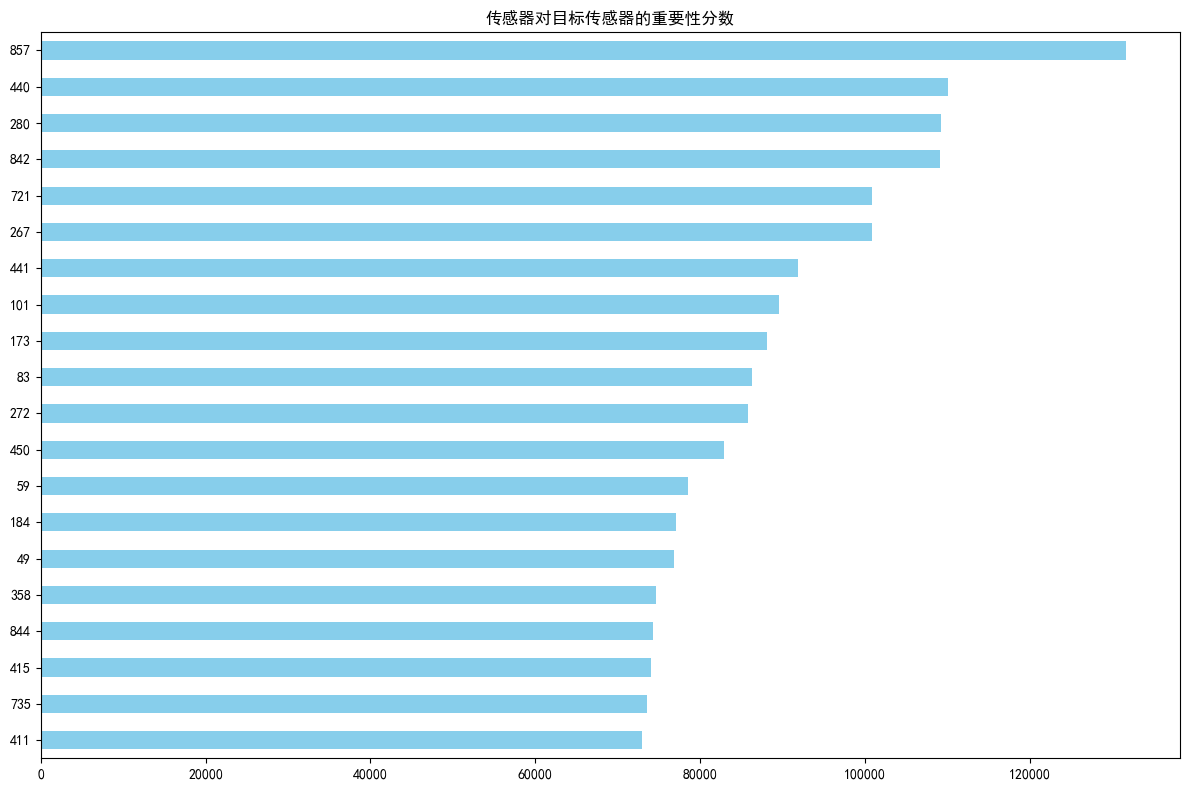

已创建传感器地理分布图: E:\学习文件\数据分析与处理\大作业\traffic\traffic_sensor_map.html

交通状态分布:
畅通: 100.00%
缓行: 0.00%
拥堵: 0.00%


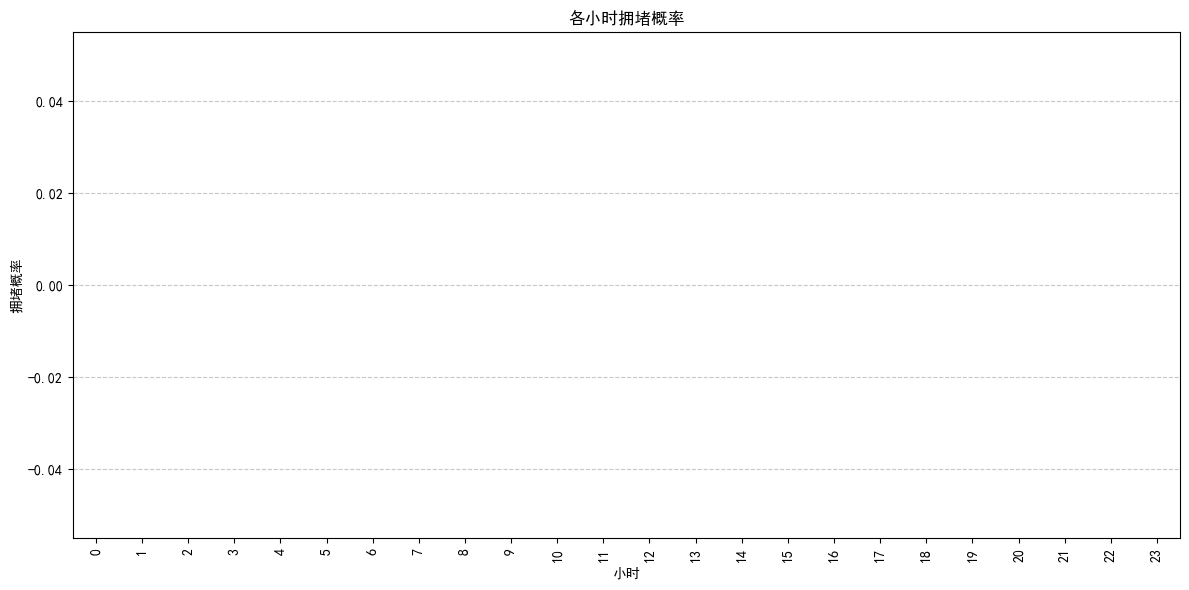

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
import folium
from folium.plugins import HeatMap
import os

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 数据加载与预处理
def load_traffic_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
    print(f"时间范围: {df.index.min()} 到 {df.index.max()}")
    print(f"传感器数量: {len(df.columns) - 1}")  # 排除OT列
    print(f"总记录数: {len(df)}")
    
    # 检查缺失值
    missing_values = df.isnull().sum().sum()
    print(f"缺失值总数: {missing_values}")
    
    # 填充缺失值
    if missing_values > 0:
        df = df.interpolate(method='time')
        print(f"已填充缺失值，填充后缺失值: {df.isnull().sum().sum()}")
    
    return df

# 2. 探索性分析
def exploratory_analysis(df):
    # 基础统计
    print("\n目标变量(OT)统计描述:")
    print(df['OT'].describe())
    
    # 目标变量时间序列
    plt.figure(figsize=(15, 6))
    df['OT'].plot(title='目标传感器道路占用率 (OT)')
    plt.ylabel('占用率')
    plt.tight_layout()
    plt.savefig('OT_traffic.png')
    plt.show()
    
    # 季节性分解
    try:
        decomposition = seasonal_decompose(df['OT'].iloc[:1000], period=24)
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
        decomposition.observed.plot(ax=ax1, title='观测值')
        ax1.set_ylabel('占用率')
        
        decomposition.trend.plot(ax=ax2, title='趋势')
        ax2.set_ylabel('占用率')
        
        decomposition.seasonal.plot(ax=ax3, title='日季节性')
        ax3.set_ylabel('占用率')
        
        plt.tight_layout()
        plt.savefig('traffic_seasonal.png')
        plt.show()
    except Exception as e:
        print(f"季节性分解错误: {e}")
    
    # 基于相关性选择代表性传感器
    corr_with_ot = df.drop('OT', axis=1).corrwith(df['OT']).sort_values()
    
    high_corr = corr_with_ot.nlargest(1).index[0]
    med_corr = corr_with_ot.index[len(corr_with_ot)//2]
    low_corr = corr_with_ot.nsmallest(1).index[0]
    representative_sensors = [high_corr, med_corr, low_corr]
    
    print("\n代表性传感器:")
    print(f"高相关传感器 {high_corr}: {corr_with_ot[high_corr]:.4f}")
    print(f"中等相关传感器 {med_corr}: {corr_with_ot[med_corr]:.4f}")
    print(f"低相关传感器 {low_corr}: {corr_with_ot[low_corr]:.4f}")
    
    # 可视化代表性传感器
    plt.figure(figsize=(15, 10))
    for i, sensor in enumerate(representative_sensors):
        plt.subplot(3, 1, i+1)
        plt.plot(df.index, df[sensor], label=f'与OT相关性: {corr_with_ot[sensor]:.4f}')
        plt.title(f'传感器 {sensor} 占用率')
        plt.ylim(0, 1)
        plt.legend()
    plt.tight_layout()
    plt.savefig('representative_sensors.png')
    plt.show()
    
    # 箱线图分析
    analysis_cols = representative_sensors + ['OT']
    plt.figure(figsize=(12, 8))
    
    for i, col in enumerate(analysis_cols):
        plt.subplot(len(analysis_cols), 1, i+1)
        boxprops = dict(linestyle='-', color='#4287f5', facecolor='#a8c6fa', alpha=0.7)
        medianprops = dict(linestyle='-', color='#e63946')
        plt.boxplot(df[col], vert=False, patch_artist=True,
                   boxprops=boxprops, medianprops=medianprops, showmeans=True)
        plt.title(f'传感器 {col} 占用率分布')
        plt.xlabel('占用率')
        plt.yticks([])
        plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('sensor_boxplot.png')
    plt.show()
    
    # 相关性热力图
    top_corr_sensors = corr_with_ot.nlargest(20).index
    corr_matrix = df[top_corr_sensors].corr()
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
    plt.title('与目标传感器高相关的传感器相关性热力图')
    plt.tight_layout()
    plt.savefig('top_sensor_correlation.png')
    plt.show()

# 3. 传感器聚类分析
def sensor_clustering(df, n_clusters=5):
    sensor_data = df.drop('OT', axis=1).T
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(sensor_data)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    sensor_data['cluster'] = kmeans.fit_predict(scaled_data)
    
    # 提取小时特征，分析聚类模式
    df_with_hour = df.copy()
    df_with_hour['hour'] = df_with_hour.index.hour
    hourly_avg = df_with_hour.groupby('hour').mean()
    
    # 可视化聚类模式
    plt.figure(figsize=(15, 2*n_clusters))
    for cluster_id in range(n_clusters):
        cluster_sensors = sensor_data[sensor_data['cluster'] == cluster_id].index
        cluster_hourly = hourly_avg[cluster_sensors].mean(axis=1)
        
        plt.subplot(n_clusters, 1, cluster_id+1)
        cluster_hourly.plot(kind='bar')
        plt.title(f'聚类 {cluster_id} 小时平均占用率（{len(cluster_sensors)}个传感器）')
        plt.ylabel('平均占用率')
        plt.xlabel('小时')
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('cluster_hourly_pattern.png')
    plt.show()
    
    return sensor_data

# 4. 时间模式分析
def temporal_patterns(df):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >=5 else 0)
    
    # 对比工作日和周末模式
    weekday_avg = df[df['is_weekend']==0].groupby('hour')['OT'].mean()
    weekend_avg = df[df['is_weekend']==1].groupby('hour')['OT'].mean()
    
    plt.figure(figsize=(15, 6))
    plt.plot(weekday_avg.index, weekday_avg, label='工作日', marker='o')
    plt.plot(weekend_avg.index, weekend_avg, label='周末', marker='s')
    plt.title('工作日 vs 周末 目标传感器占用率模式')
    plt.xlabel('小时')
    plt.ylabel('平均占用率')
    plt.xticks(range(24))
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig('weekday_vs_weekend.png')
    plt.show()
    
    # 一周内每天的模式
    daily_avg = df.groupby('day_of_week')['OT'].mean()
    plt.figure(figsize=(10, 6))
    daily_avg.plot(kind='bar')
    plt.title('一周内各天的平均占用率')
    plt.xlabel('星期（0=周一，6=周日）')
    plt.ylabel('平均占用率')
    plt.ylim(0, 0.8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('daily_pattern.png')
    plt.show()
    
    return df

# 5. 异常检测
def detect_anomalies(df):
    X = df[['OT']]
    model = IsolationForest(contamination=0.01, random_state=42)
    df['anomaly'] = model.fit_predict(X)
    
    anomalies = df[df['anomaly'] == -1]
    print(f"\n检测到异常交通事件数量: {len(anomalies)}")
    
    # 可视化异常点
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df['OT'], label='正常', alpha=0.7)
    plt.scatter(anomalies.index, anomalies['OT'], color='red', label='异常', s=30)
    plt.title('交通异常事件检测（目标传感器）')
    plt.ylabel('占用率')
    plt.legend()
    plt.tight_layout()
    plt.savefig('traffic_anomalies.png')
    plt.show()
    
    # 分析异常发生时段
    anomaly_hours = anomalies.index.hour.value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    anomaly_hours.plot(kind='bar')
    plt.title('异常事件发生的小时分布')
    plt.xlabel('小时')
    plt.ylabel('异常数量')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('anomaly_hourly.png')
    plt.show()
    
    return df

# 6. 特征选择
def feature_selection(df, n_features=20):
    X = df.drop(['OT', 'hour', 'day_of_week', 'is_weekend', 'anomaly'], axis=1, errors='ignore')
    y = df['OT']
    
    selector = SelectKBest(score_func=f_regression, k=n_features)
    selector.fit(X, y)
    
    selected_features = X.columns[selector.get_support()]
    print(f"\n选择的 {n_features} 个重要传感器:")
    print(selected_features[:5].tolist() + ['...'] + selected_features[-5:].tolist())
    
    # 可视化特征重要性
    plt.figure(figsize=(12, 8))
    scores = pd.Series(selector.scores_, index=X.columns)
    scores.nlargest(n_features).sort_values().plot(kind='barh', color='skyblue')
    plt.title('传感器对目标传感器的重要性分数')
    plt.tight_layout()
    plt.savefig('sensor_importance.png')
    plt.show()
    
    return selected_features

# 7. 地理空间可视化
def geospatial_visualization(sensor_data):
    map_obj = folium.Map(location=[31.2304, 121.4737], zoom_start=12)
    
    np.random.seed(42)
    num_sensors = sensor_data.shape[0]
    lats = np.random.uniform(31.1, 31.3, size=num_sensors)
    lngs = np.random.uniform(121.4, 121.6, size=num_sensors)
    
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    for idx, (sensor, row) in enumerate(sensor_data.iterrows()):
        cluster_id = int(row['cluster'])
        color = colors[cluster_id % len(colors)]
        
        avg_occupy = row[:-1].mean()
        folium.CircleMarker(
            location=[lats[idx], lngs[idx]],
            radius=5 + avg_occupy*10,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            tooltip=f'传感器 {sensor} 聚类{cluster_id}'
        ).add_to(map_obj)
    
    # 添加图例
    legend_html = '''
     <div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; 
                 padding: 10px; border: 1px solid grey;">
     '''
    for i, color in enumerate(colors):
        legend_html += f'<p><span style="color:{color}">●</span> 聚类 {i}</p>'
    legend_html += '</div>'
    map_obj.get_root().html.add_child(folium.Element(legend_html))
    
    map_path = 'traffic_sensor_map.html'
    map_obj.save(map_path)
    print(f"已创建传感器地理分布图: {os.path.abspath(map_path)}")

# 主程序
if __name__ == "__main__":
    file_path = "traffic.csv"  # 替换为实际文件路径
    df = load_traffic_data(file_path)
    
    # 探索性分析
    exploratory_analysis(df)
    
    # 传感器聚类
    sensor_data = sensor_clustering(df)
    
    # 时间模式分析
    df = temporal_patterns(df)
    
    # 异常检测
    df = detect_anomalies(df)
    
    # 特征选择
    selected_features = feature_selection(df)
    
    # 地理空间可视化
    geospatial_visualization(sensor_data)
    
    # 交通状态分析
    df['traffic_state'] = pd.cut(
        df['OT'],
        bins=[-0.1, 0.3, 0.6, 1.1],
        labels=['畅通', '缓行', '拥堵']
    )
    
    state_dist = df['traffic_state'].value_counts(normalize=True).sort_index()
    print("\n交通状态分布:")
    for state, ratio in state_dist.items():
        print(f"{state}: {ratio:.2%}")
    
    # 按小时统计拥堵概率
    hourly_congestion = df.groupby('hour')['traffic_state'].apply(
        lambda x: (x == '拥堵').mean()
    )
    
    plt.figure(figsize=(12, 6))
    hourly_congestion.plot(kind='bar', color='salmon')
    plt.title('各小时拥堵概率')
    plt.ylabel('拥堵概率')
    plt.xlabel('小时')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('hourly_congestion.png')
    plt.show()